<a href="https://colab.research.google.com/github/Agalip/Covid/blob/main/covid_mobility_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

January 2022

@Ahmet Galip Şengün - ahmetgalipsengun@gmail.com

Istanbul Medeniyet University

# Clustering Countries by Covid-19 Community Mobility Reports and Visualization on World Map

## Introduction

## Initial imports and installs

In [6]:
pip install geopandas

In [7]:
pip install folium

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
%matplotlib inline

## Google Mobility Data

These Community Mobility Reports aim to provide insights into what has changed in response to policies aimed at combating COVID-19. The reports chart movement trends over time by geography, across different categories of places such as retail and recreation, groceries and pharmacies, parks, transit stations, workplaces, and residential.

More details on the data can be found on the Google's Mobility Reports website

https://www.google.com/covid19/mobility/data_documentation.html?hl=en

Accessing to dataset through local csv file,

The dataset can be downloaded from https://www.google.com/covid19/mobility/

In [10]:
##data = pd.read_csv('Global_Mobility_Report.csv', low_memory=False)
data = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv', low_memory=False)
data.drop('census_fips_code', axis =1, inplace = True)

In [11]:
data = data.set_index('date')
data.index = pd.to_datetime(data.index)

In [12]:
data.describe()

retail_and_recreation_percent_change_from_baseline  ...  residential_percent_change_from_baseline
count                                       5.111115e+06   ...                              4.997573e+06
mean                                       -1.380366e+01   ...                              7.178069e+00
std                                         2.951890e+01   ...                              7.537662e+00
min                                        -1.000000e+02   ...                             -7.100000e+01
25%                                        -3.000000e+01   ...                              2.000000e+00
50%                                        -1.100000e+01   ...                              6.000000e+00
75%                                         4.000000e+00   ...                              1.100000e+01
max                                         6.160000e+02   ...                              7.000000e+01

[8 rows x 6 columns]

In [13]:
data

country_region_code  ... residential_percent_change_from_baseline
date                            ...                                         
2020-02-15                  AE  ...                                      1.0
2020-02-16                  AE  ...                                      1.0
2020-02-17                  AE  ...                                      1.0
2020-02-18                  AE  ...                                      1.0
2020-02-19                  AE  ...                                      1.0
...                        ...  ...                                      ...
2021-12-27                  ZW  ...                                      NaN
2021-12-28                  ZW  ...                                      NaN
2021-12-29                  ZW  ...                                      NaN
2021-12-30                  ZW  ...                                      NaN
2021-12-31                  ZW  ...                                      NaN

[8255156 rows x 13 columns]

### Inspecting the data

Plotting of graphs for observing the mobility data of several countries during the covid period in order to
check how different the mobility reports can be in different countries

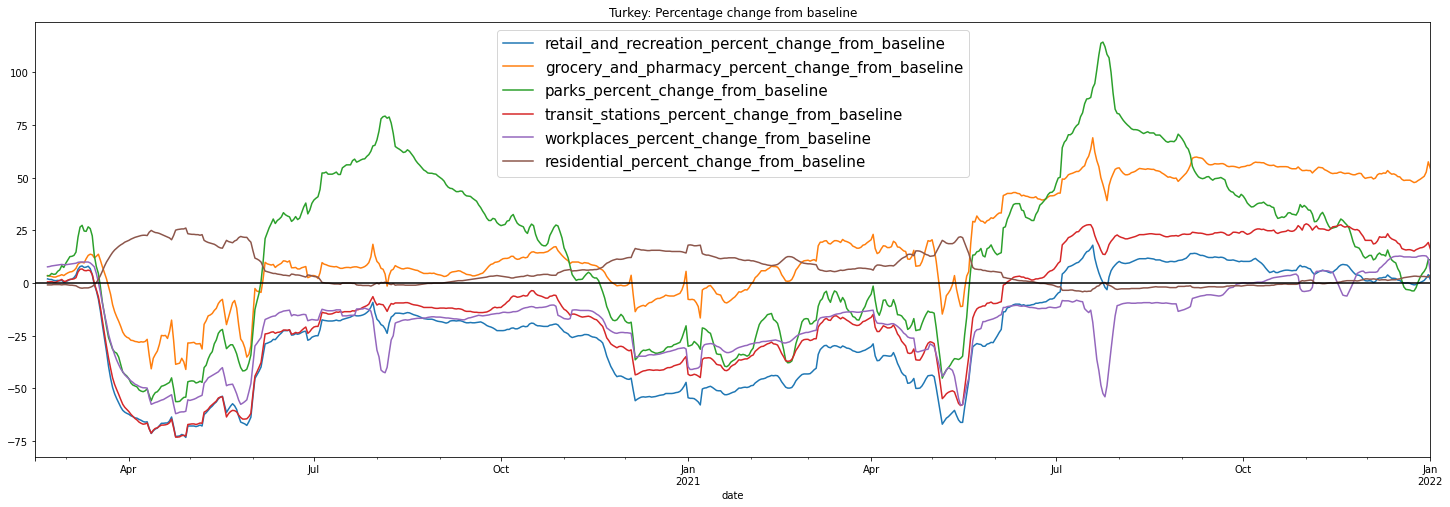

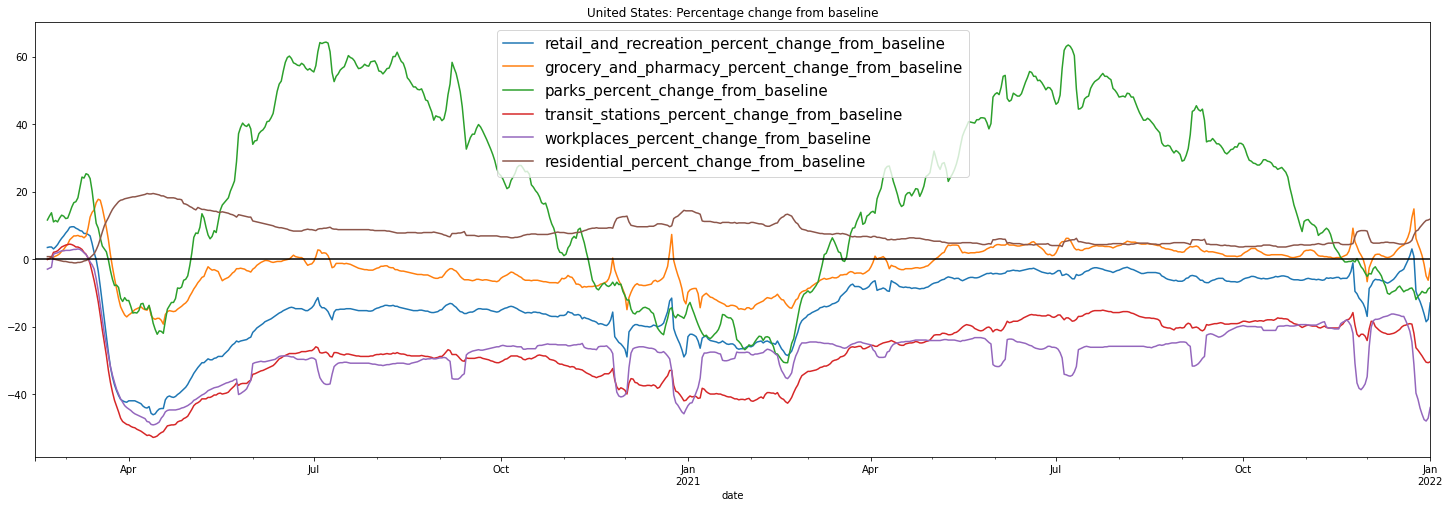

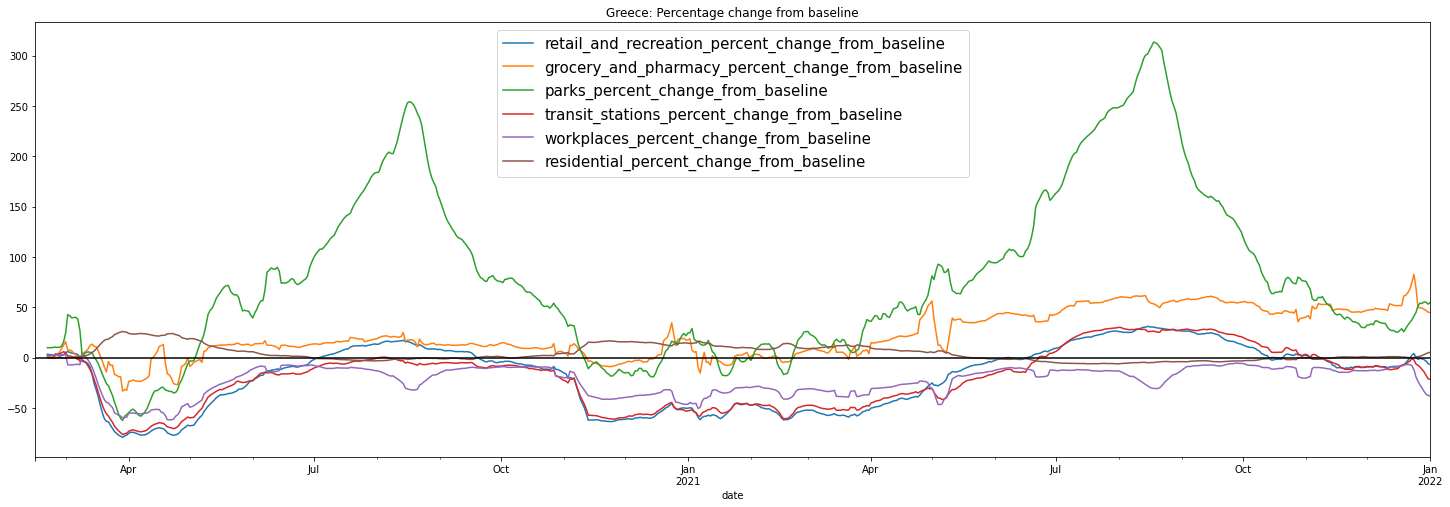

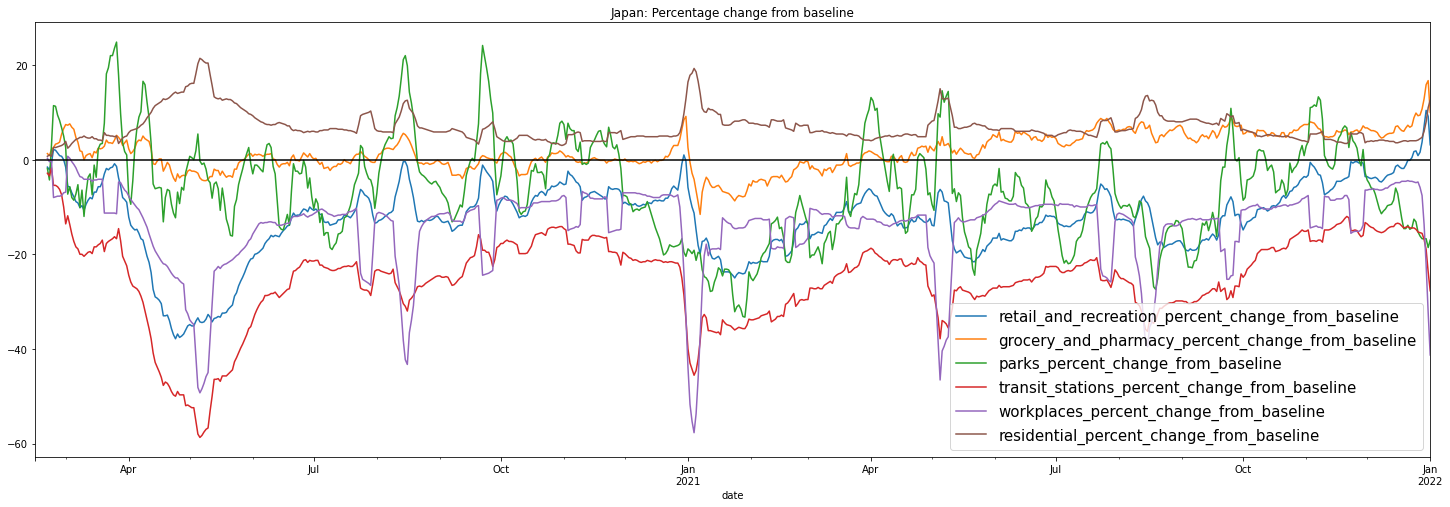

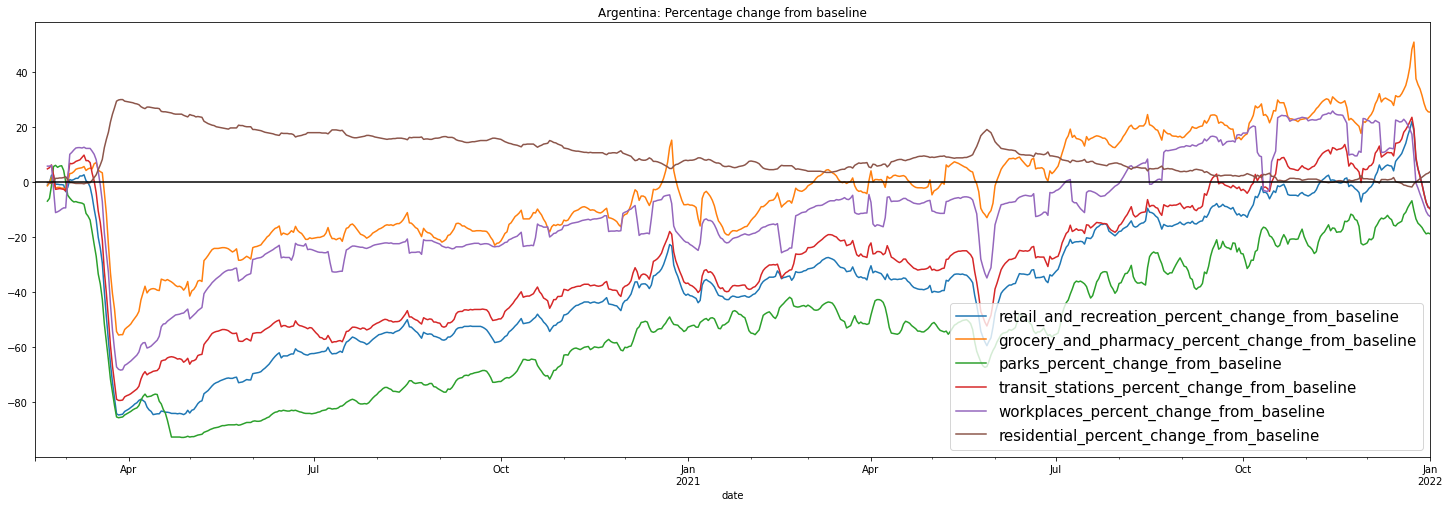

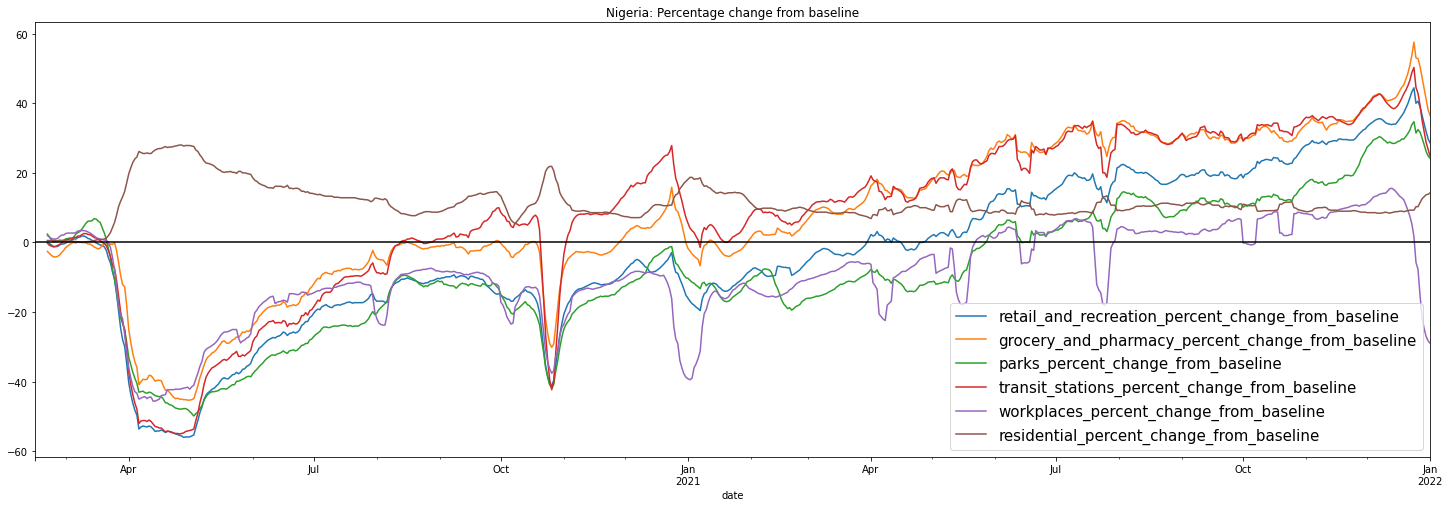

In [14]:
countries = ['Turkey', 'United States', 'Greece', 'Japan', 'Argentina', 'Nigeria']
for country in countries:
    country_data = data.query('country_region == @country')
    country_data[country_data['sub_region_1'].isnull()].drop(['sub_region_1', 'sub_region_2'], axis=1).rolling(7).mean().plot(figsize = (25,8))
    plt.legend(loc="best", fontsize =15)
    plt.axhline(y=0, color='black', linestyle='-')
    plt.title(country+': Percentage change from baseline')

## The relationship between the mobility categories

KeyboardInterrupt: ignored

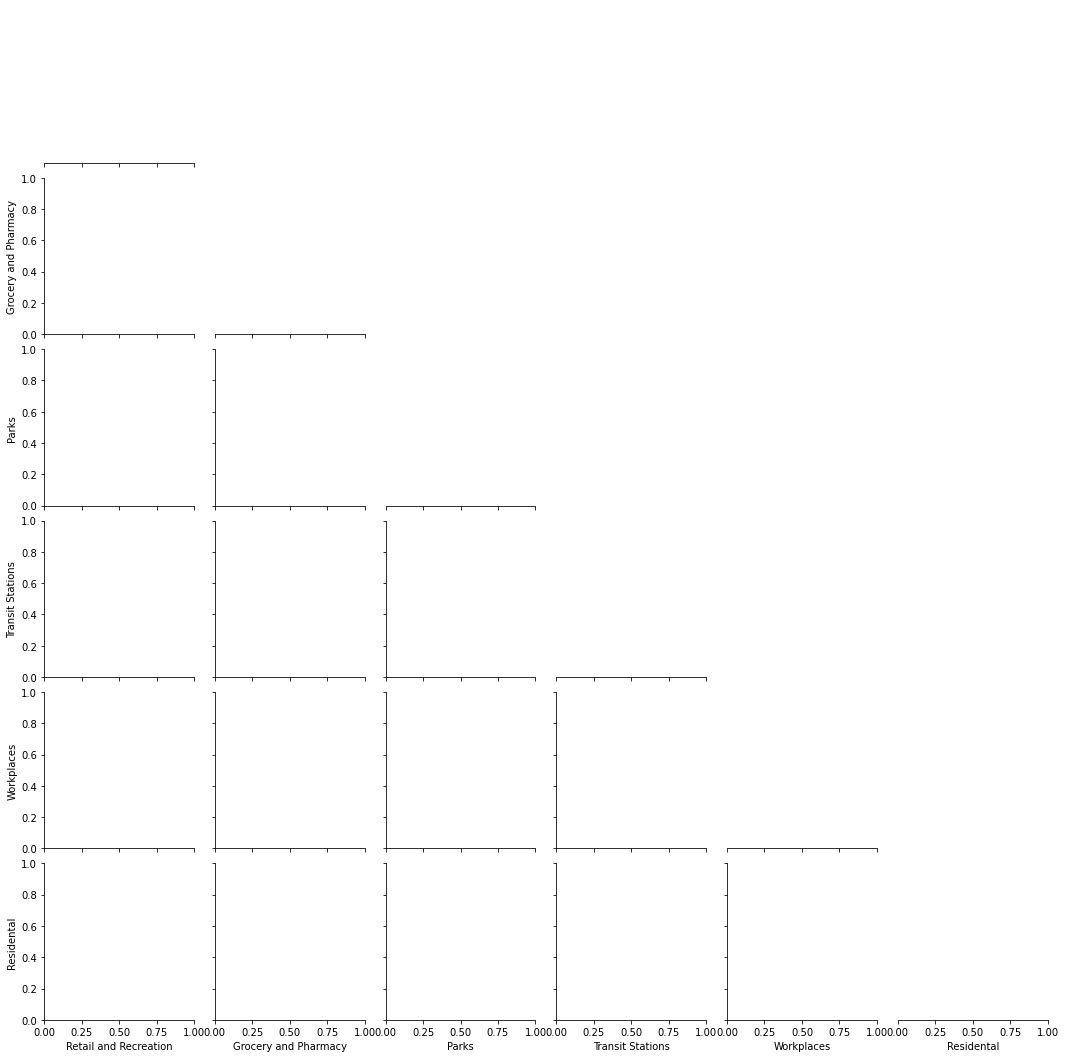

In [49]:
country = 'Turkey'
renamed_data = data.rename({'retail_and_recreation_percent_change_from_baseline' : 'Retail and Recreation',
                           'grocery_and_pharmacy_percent_change_from_baseline' : 'Grocery and Pharmacy',
                           'parks_percent_change_from_baseline' : 'Parks',
                           'transit_stations_percent_change_from_baseline' : 'Transit Stations',
                           'workplaces_percent_change_from_baseline' : 'Workplaces',
                           'residential_percent_change_from_baseline' : 'Residental'}, axis=1)
country_data = renamed_data.query('country_region == @country')
g = sns.pairplot(country_data.iloc[:,7:], corner = True)
g.fig.suptitle(country+ ": The relationship between the mobility categories against each other")

## High Dimensional Clustering

### Preprocessing for High Dimensional Clustering

In [51]:
clustering_gmt_df = data.groupby('country_region').mean().reset_index()
clustering_gmt_df.head()

country_region  ...  residential_percent_change_from_baseline
0          Afghanistan  ...                                  3.840343
1               Angola  ...                                  4.366812
2  Antigua and Barbuda  ...                                  1.110909
3            Argentina  ...                                  7.754503
4                Aruba  ...                                  1.852632

[5 rows x 7 columns]

In [52]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

X = clustering_gmt_df.iloc[:,1:]
X = X.fillna(0)
X = StandardScaler().fit_transform(X) 

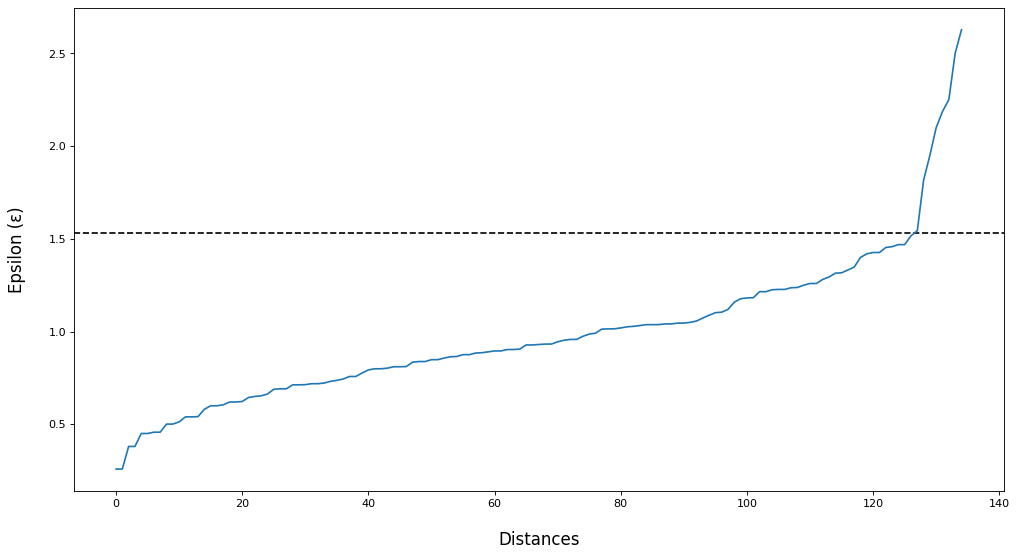

In [53]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

# next, we sort and plot the results
distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.figure(figsize = (15,8), dpi = 80)
plt.xlabel("Distances", fontdict= {'size':15}, labelpad= 20)
plt.ylabel("Epsilon (ɛ)", fontdict= {'size':15}, labelpad= 20)
plt.axhline(1.53, linestyle='--', color='k')
plt.plot(distances)

### DBSCAN Clustering

Estimated number of clusters: 2
Estimated number of noise points: 17


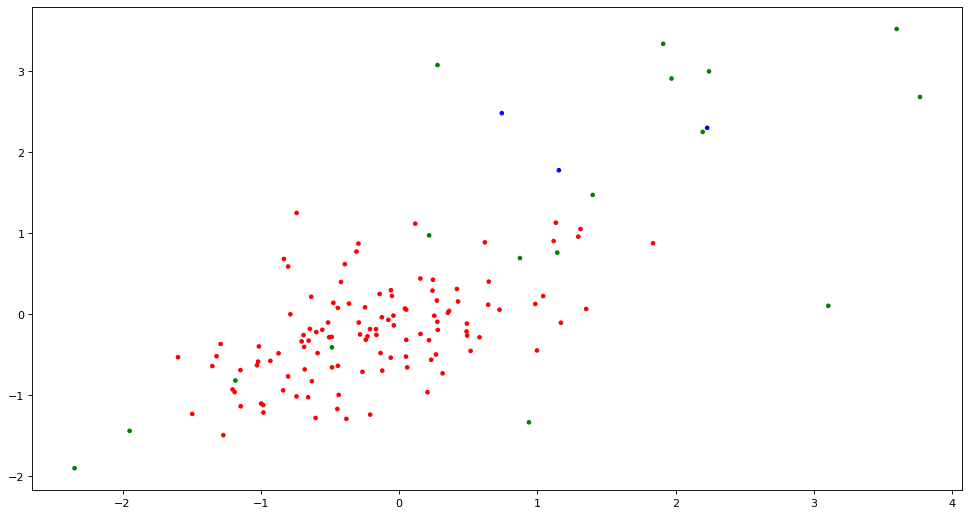

In [19]:
m = DBSCAN(eps=1.53)
m.fit(X)

core_samples_mask = np.zeros_like(m.labels_, dtype=bool)
core_samples_mask[m.core_sample_indices_] = True
labels = m.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

colors = ['red', 'blue', 'green']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
plt.figure(figsize = (15,8), dpi = 80)
plt.scatter(X[:,0], X[:,1], c=vectorizer(labels), s=10)

In [20]:
clustering_gmt_df['cluster'] = labels
clustering_gmt_df.groupby('cluster').mean().reset_index()

cluster  ...  residential_percent_change_from_baseline
0       -1  ...                                  3.844046
1        0  ...                                  6.214055
2        1  ...                                  3.664131

[3 rows x 7 columns]

In [21]:
clusters = np.array(clustering_gmt_df['cluster'].unique())
clusters= np.sort(clusters)

In [22]:
def print_clusters(clusters):
    for i in clusters:
        print("\n")
        print(str(i)+ ". cluster")
        print("--------------------------------------------------------------------------------------------------------------------")
        print(clustering_gmt_df[clustering_gmt_df['cluster'] == i]['country_region'].values.tolist(), end=" ")
        print("\n--------------------------------------------------------------------------------------------------------------------")

In [23]:
print_clusters(clusters)



-1. cluster
--------------------------------------------------------------------------------------------------------------------
['Burkina Faso', 'Cameroon', 'Cape Verde', "Côte d'Ivoire", 'Egypt', 'Iraq', 'Kazakhstan', 'Lebanon', 'Libya', 'Mali', 'Mongolia', 'Myanmar (Burma)', 'Niger', 'Panama', 'Papua New Guinea', 'Rwanda', 'Yemen'] 
--------------------------------------------------------------------------------------------------------------------


0. cluster
--------------------------------------------------------------------------------------------------------------------
['Angola', 'Antigua and Barbuda', 'Argentina', 'Aruba', 'Australia', 'Austria', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Cambodia', 'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Croatia', 'Czechia', 'Denmark', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Fiji', 'Finland', 'France', 'Gabon', 'Georgia', 'German

In [24]:
def clusterCountries(n):
    df0 = pd.DataFrame(data['country_region'].unique(), columns = ['Country'])
    df0['Clusters'] = np.nan
    df0 = df0.set_index('Country')
    for i in n:
        df0.loc[clustering_gmt_df[clustering_gmt_df['cluster'] == i]['country_region'].values.tolist(), 'Clusters'] = i
    return df0
df0 = clusterCountries(clusters)

### DBSCAN visualization on world map

In [25]:
import folium
def showMap(df0):
    world = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))

    world.iloc[4,2] = "United States"
    yeniDf = world.merge(df0, how="left", left_on=['name'], right_on=['Country'])

    my_map = folium.Map()

    # Add the data
    folium.Choropleth(
        geo_data=yeniDf,
        data=yeniDf,
        name='choropleth',
        columns=['name', 'Clusters'],
        fill_color='YlGnBu',
        smooth_factor =1,
        key_on='feature.properties.name',
        fill_opacity=0.8,
        line_opacity=0.5,
        overlay = True,
        legend_name='Clusters',
        nan_fill_color = 'White'
    ).add_to(my_map)
    return my_map
showMap(df0)

## 2 Dimensional Clustering for parks and residental change from baseline

In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [27]:
clustering_gmt_df = data.groupby('country_region').mean().reset_index() ##resetting
dim2_clustering_df = clustering_gmt_df[['parks_percent_change_from_baseline', 'residential_percent_change_from_baseline']]
dim2_clustering_df = dim2_clustering_df.fillna(0)
X = StandardScaler().fit_transform(dim2_clustering_df)

### Selecting the number of clusters with silhouette analysis

In [28]:
def silhouetteAnalysis(X):
    range_n_clusters = [3, 4, 5, 6]
    silhouette_avg_max = -1
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        if silhouette_avg > silhouette_avg_max:
            silhouette_avg_max = silhouette_avg
            opt_n_clusters = n_clusters
            
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')
    
    print("choosen cluster size: " + str(opt_n_clusters))    
    plt.show()
    return opt_n_clusters

For n_clusters = 3 The average silhouette_score is : 0.3923071191564514
For n_clusters = 4 The average silhouette_score is : 0.37963186962616213
For n_clusters = 5 The average silhouette_score is : 0.37748932104635163
For n_clusters = 6 The average silhouette_score is : 0.37671089666331337
choosen cluster size: 3


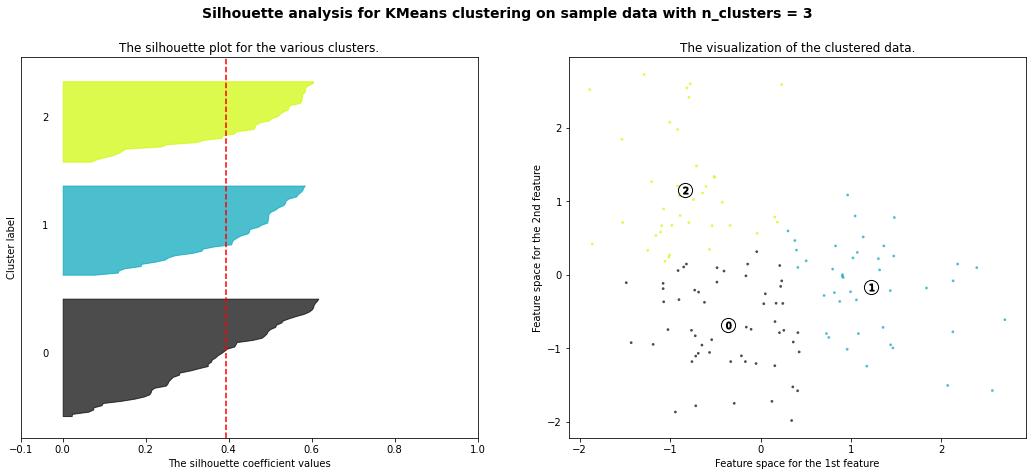

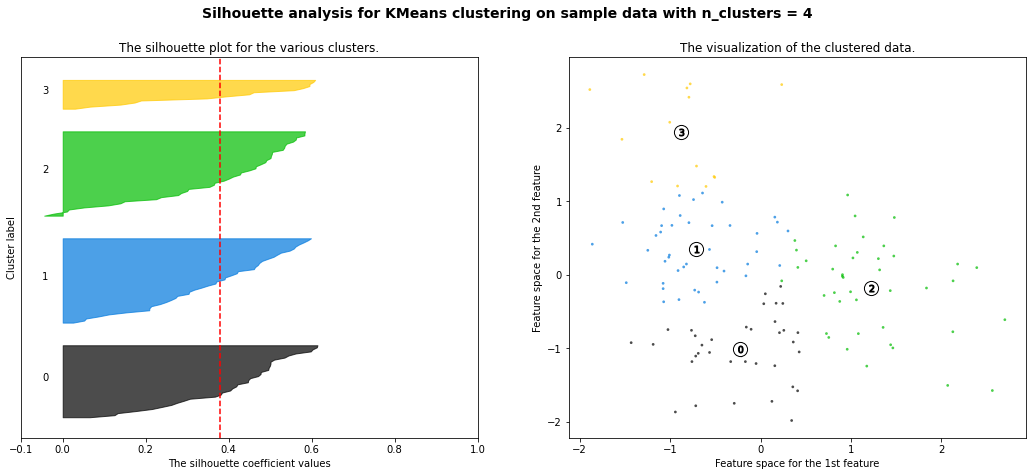

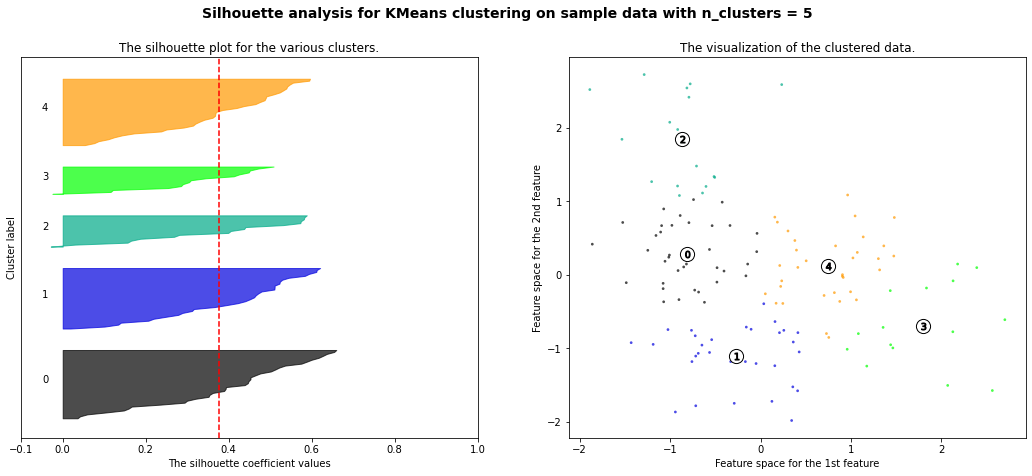

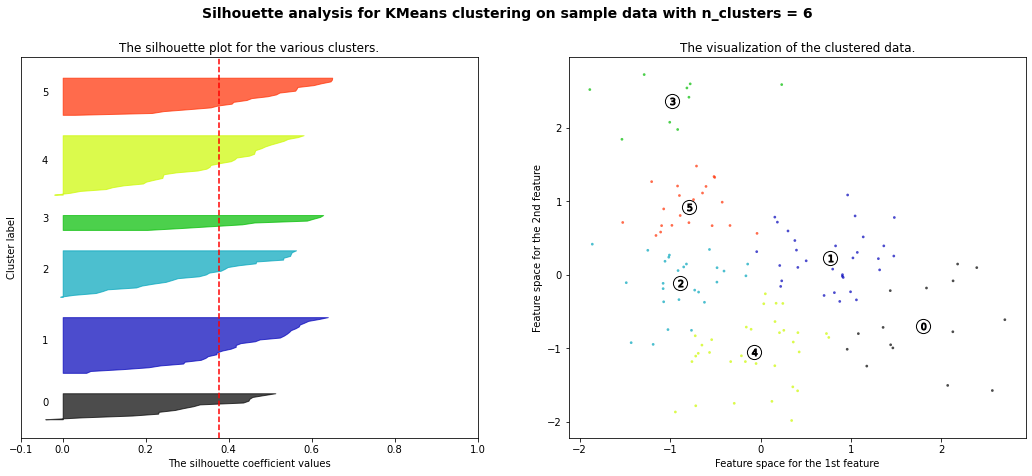

3

In [29]:
silhouetteAnalysis(X)

### Determining number of clusters from Dendrogram

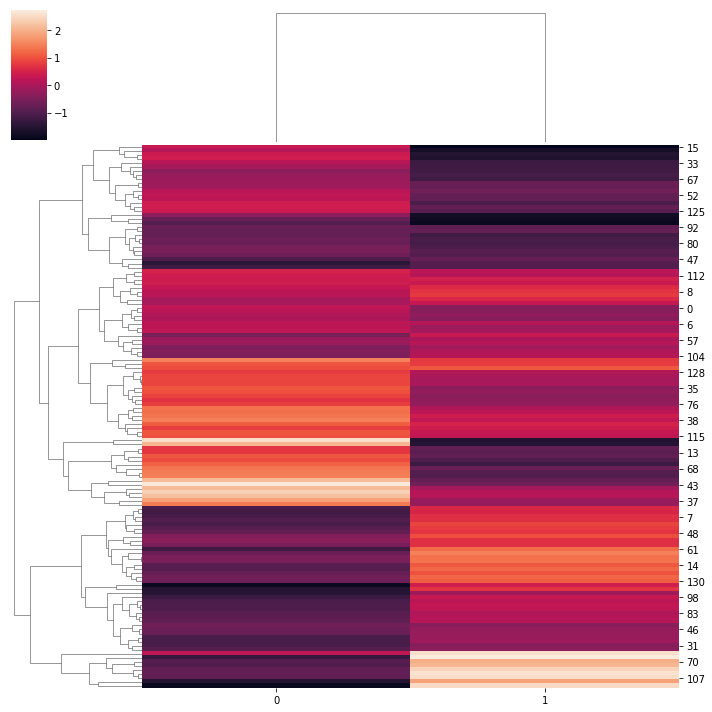

In [30]:
sns.clustermap(X)

### Kmeans Clustering

In [31]:
n_clusters = 5
kmeans = KMeans(n_clusters = n_clusters)
kmeans.fit(X)
clusters = kmeans.predict(X)
centroids = kmeans.cluster_centers_

In [32]:
clustering_gmt_df['cluster'] = clusters
clustering_gmt_df.groupby('cluster').mean().reset_index()

cluster  ...  residential_percent_change_from_baseline
0        0  ...                                 14.239797
1        1  ...                                  0.754741
2        2  ...                                  6.530787
3        3  ...                                  6.879377
4        4  ...                                  2.361377

[5 rows x 7 columns]

In [33]:
print_clusters(range(n_clusters))



0. cluster
--------------------------------------------------------------------------------------------------------------------
['Bolivia', 'Cambodia', 'Chile', 'Ecuador', 'Fiji', 'Ghana', 'India', 'Kuwait', 'Malaysia', 'Myanmar (Burma)', 'Panama', 'Peru', 'Philippines', 'Rwanda', 'Singapore', 'South Africa', 'Sri Lanka', 'Uganda', 'Venezuela'] 
--------------------------------------------------------------------------------------------------------------------


1. cluster
--------------------------------------------------------------------------------------------------------------------
['Afghanistan', 'Aruba', 'Barbados', 'Belarus', 'Benin', 'Bosnia and Herzegovina', 'Bulgaria', 'Cameroon', "Côte d'Ivoire", 'Egypt', 'Georgia', 'Guinea-Bissau', 'Iraq', 'Kazakhstan', 'Kyrgyzstan', 'Lebanon', 'Liechtenstein', 'Moldova', 'Mozambique', 'Namibia', 'Nicaragua', 'Niger', 'Oman', 'Pakistan', 'Papua New Guinea', 'Romania', 'Russia', 'Réunion', 'Senegal', 'Serbia', 'Tajikistan', 'Tanzania', '

In [34]:
df0 = clusterCountries(range(n_clusters))

### Kmeans Visualization on world map

In [35]:
showMap(df0)

## 2 Dimensional Clustering for workplace and retail&recreation change from baseline

### Silhuette Analysis

For n_clusters = 3 The average silhouette_score is : 0.36163234206928796
For n_clusters = 4 The average silhouette_score is : 0.3236833371739986
For n_clusters = 5 The average silhouette_score is : 0.3411868865486363
For n_clusters = 6 The average silhouette_score is : 0.32364502881343654
choosen cluster size: 3


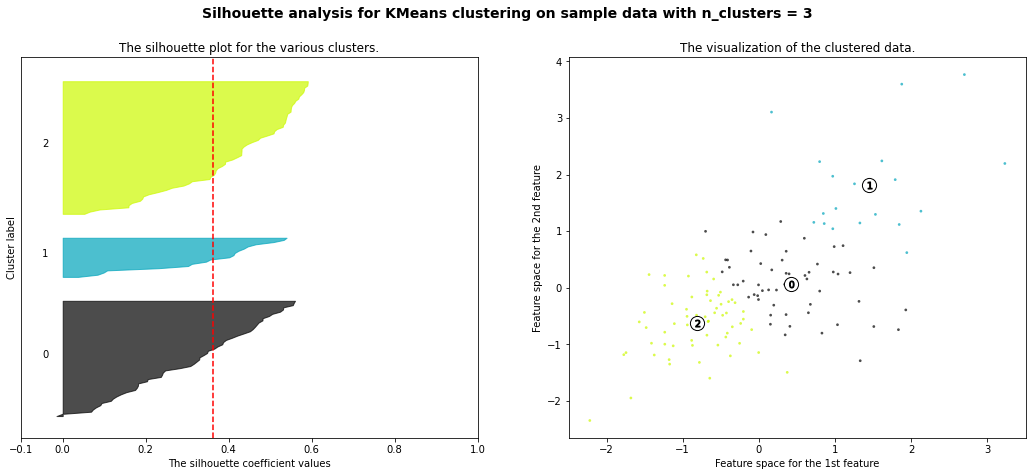

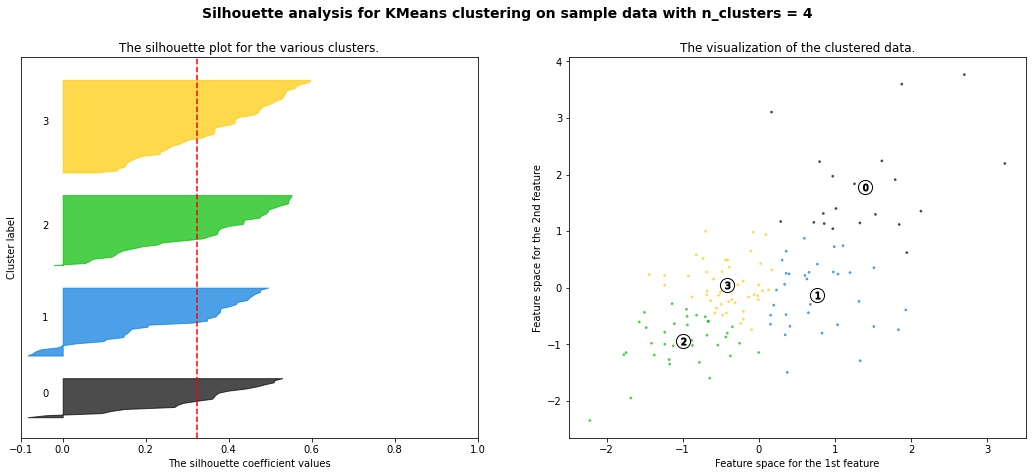

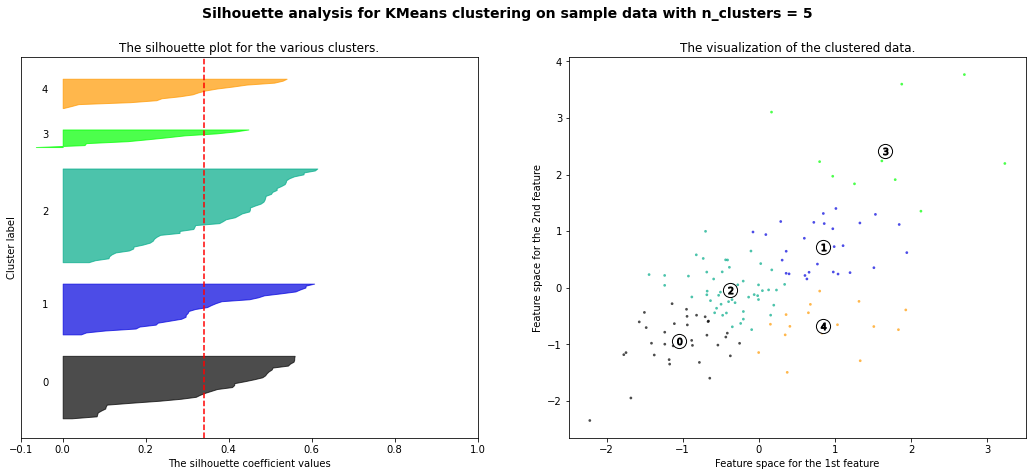

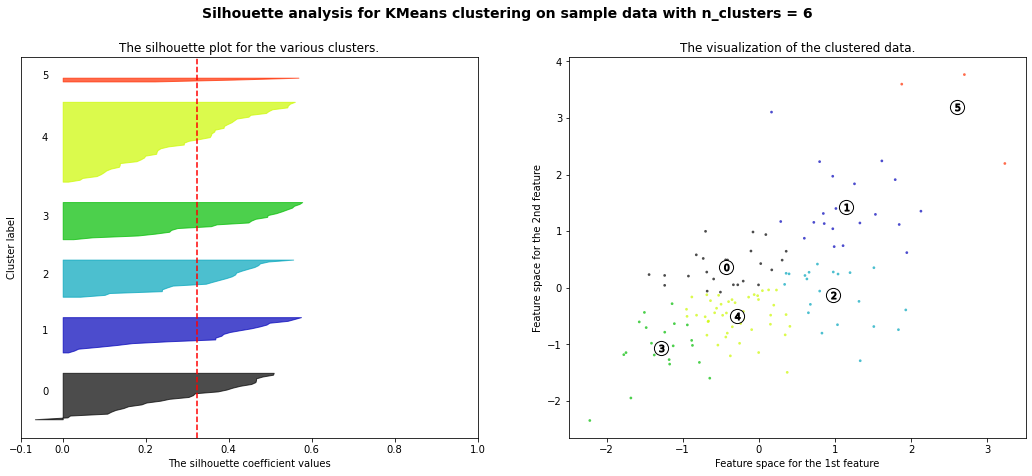

3

In [36]:
clustering_gmt_df = data.groupby('country_region').mean().reset_index() ##resetting
dim2_clustering_df = clustering_gmt_df[['workplaces_percent_change_from_baseline', 'retail_and_recreation_percent_change_from_baseline']]
dim2_clustering_df = dim2_clustering_df.fillna(0)
X = StandardScaler().fit_transform(dim2_clustering_df)
silhouetteAnalysis(X)

### Dendogram

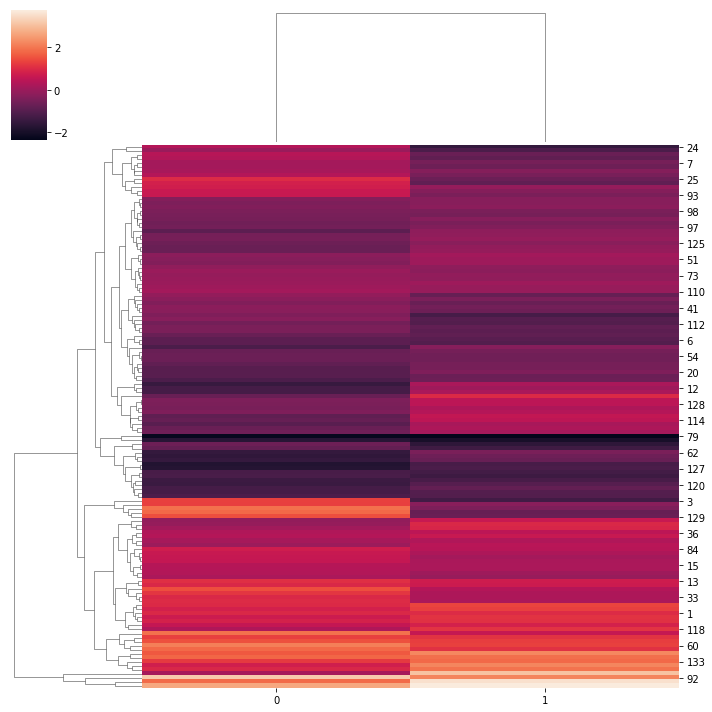

In [37]:
sns.clustermap(X)

### Kmeans clustering

In [38]:
n_clusters=3
kmeans = KMeans(n_clusters)
kmeans.fit(X)
clusters = kmeans.predict(X)
centroids = kmeans.cluster_centers_

In [39]:
clustering_gmt_df['cluster'] = clusters
clustering_gmt_df.groupby('cluster').mean().reset_index()

cluster  ...  residential_percent_change_from_baseline
0        0  ...                                  5.467160
1        1  ...                                  3.706967
2        2  ...                                  6.868724

[3 rows x 7 columns]

In [40]:
print_clusters(range(n_clusters))



0. cluster
--------------------------------------------------------------------------------------------------------------------
['Argentina', 'Aruba', 'Australia', 'Bahrain', 'Belarus', 'Benin', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Cameroon', 'Canada', 'Colombia', 'Croatia', 'Czechia', 'Denmark', 'Egypt', 'Estonia', 'Fiji', 'Finland', 'Gabon', 'Greece', 'Hong Kong', 'Hungary', 'India', 'Indonesia', 'Japan', 'Malta', 'Mauritius', 'Mexico', 'Mozambique', 'Namibia', 'New Zealand', 'Nicaragua', 'Nigeria', 'Paraguay', 'Poland', 'Qatar', 'Rwanda', 'Réunion', 'Saudi Arabia', 'Senegal', 'South Africa', 'South Korea', 'Taiwan', 'Tajikistan', 'Tanzania', 'Thailand', 'Turkey', 'Uganda', 'United Arab Emirates', 'United States', 'Uruguay', 'Venezuela', 'Vietnam'] 
--------------------------------------------------------------------------------------------------------------------


1. cluster
-----------------------------------------------------------------------------------------------

### Kmeans Visualization on world map

In [41]:
df0 = clusterCountries(range(n_clusters))
showMap(df0)

## 2 Dimensional Function

In [42]:
def call(category_1, category_2):
    clustering_gmt_df = data.groupby('country_region').mean().reset_index() ##resetting
    dim2_clustering_df = clustering_gmt_df[[category_1, category_2]]
    dim2_clustering_df = dim2_clustering_df.fillna(0)
    X = StandardScaler().fit_transform(dim2_clustering_df)
    n_clusters = silhouetteAnalysis(X)
    kmeans = KMeans(n_clusters)
    kmeans.fit(X)
    clusters = kmeans.predict(X)
    centroids = kmeans.cluster_centers_
    clustering_gmt_df['cluster'] = clusters
    clustering_gmt_df.groupby('cluster').mean().reset_index()
    print_clusters(range(n_clusters))
    df0 = clusterCountries(range(n_clusters))
    return df0

For n_clusters = 3 The average silhouette_score is : 0.45221187769203425
For n_clusters = 4 The average silhouette_score is : 0.35356905402682526
For n_clusters = 5 The average silhouette_score is : 0.34382184507363267
For n_clusters = 6 The average silhouette_score is : 0.35135317398252836
choosen cluster size: 3


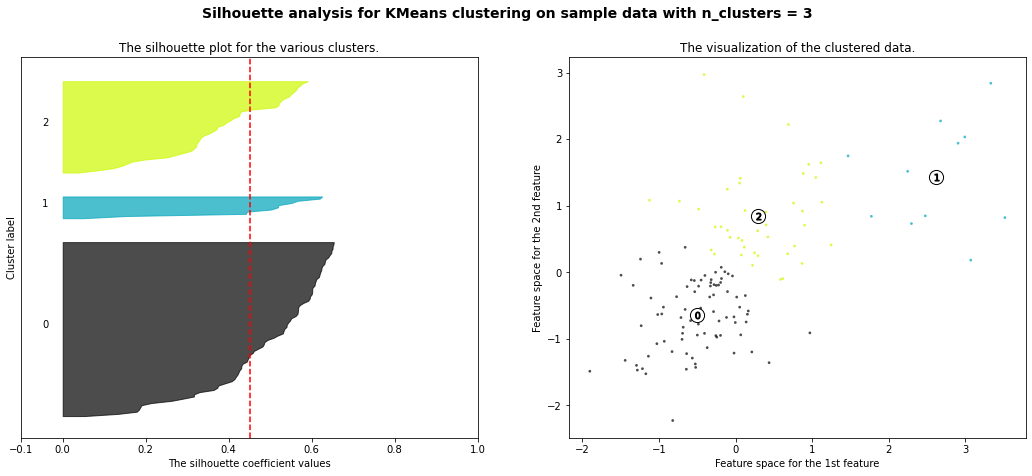

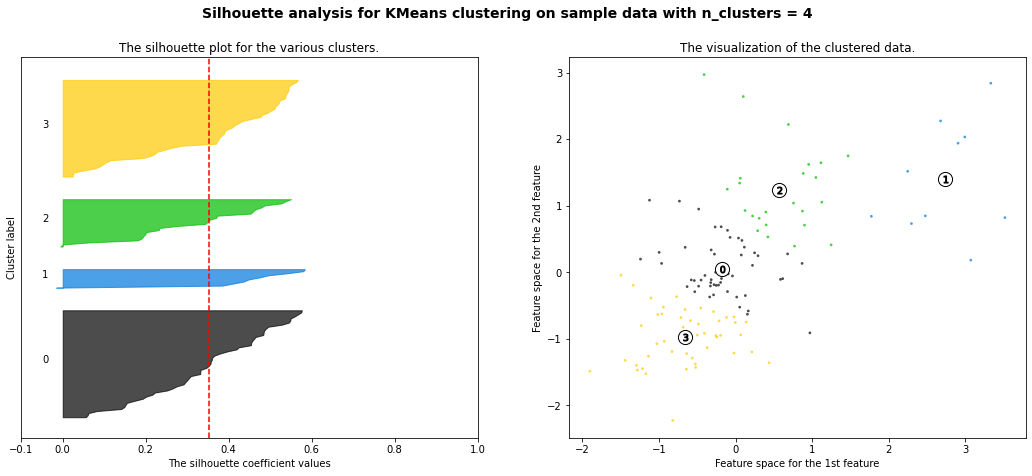

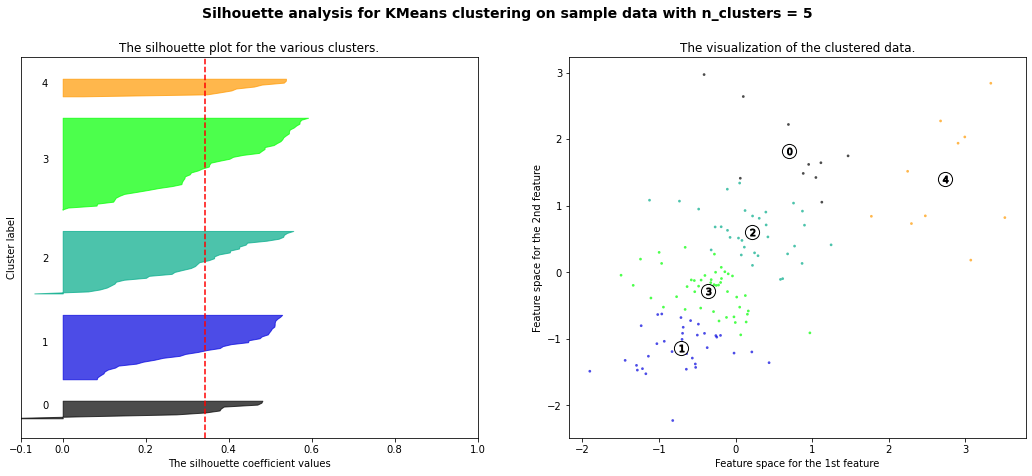

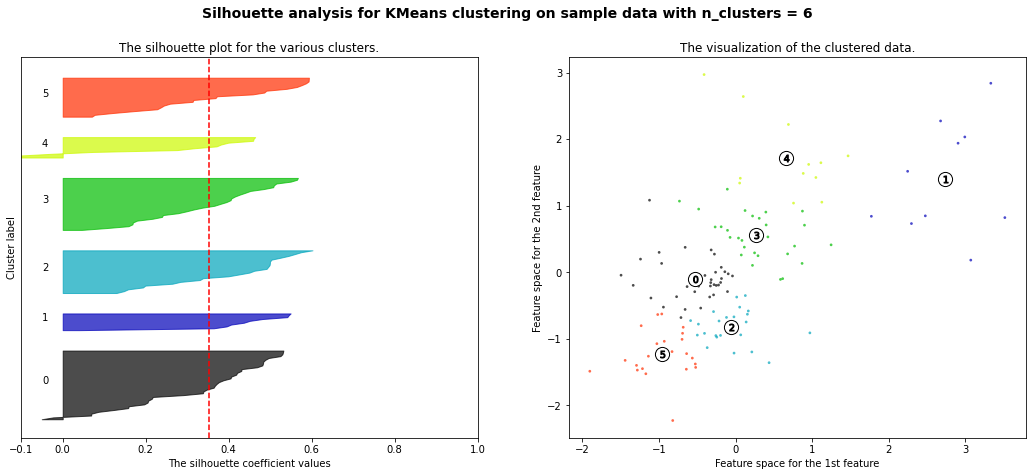



0. cluster
--------------------------------------------------------------------------------------------------------------------
['Argentina', 'Aruba', 'Australia', 'Bahrain', 'Belarus', 'Benin', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Cameroon', 'Canada', 'Colombia', 'Croatia', 'Czechia', 'Denmark', 'Egypt', 'Estonia', 'Fiji', 'Finland', 'Gabon', 'Greece', 'Hong Kong', 'Hungary', 'India', 'Indonesia', 'Japan', 'Malta', 'Mauritius', 'Mexico', 'Mozambique', 'Namibia', 'New Zealand', 'Nicaragua', 'Nigeria', 'Paraguay', 'Poland', 'Qatar', 'Rwanda', 'Réunion', 'Saudi Arabia', 'Senegal', 'South Africa', 'South Korea', 'Taiwan', 'Tajikistan', 'Tanzania', 'Thailand', 'Turkey', 'Uganda', 'United Arab Emirates', 'United States', 'Uruguay', 'Venezuela', 'Vietnam'] 
--------------------------------------------------------------------------------------------------------------------


1. cluster
-----------------------------------------------------------------------------------------------

In [47]:
df0 = call('grocery_and_pharmacy_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline')

In [48]:
showMap(df0)